In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import integrate
from scipy.interpolate import interp1d
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3
sns.set_palette("husl")

print("Bibliotheken erfolgreich importiert!")

Bibliotheken erfolgreich importiert!


In [2]:
data_path = "../../data/processed/swiss_rental_data_m2_construction_period/Durchschnittlicher_Mietpreis_m2_Bauperiode_Kanton_combined.json"

try:
    with open(data_path, 'r', encoding='utf-8') as file:
        rental_data = json.load(file)
    print(f"Daten erfolgreich geladen: {len(rental_data)} Einträge")
except FileNotFoundError:
    print(f"Datei nicht gefunden: {data_path}")
    print("Verwende Beispieldaten...")
    rental_data = [
        {
            "year": "2023",
            "canton": "Schweiz",
            "construction_periods": [
                {"construction_period": "Total", "avg_price_per_sqm": 17.4, "confidence_interval": 0.0},
                {"construction_period": "Vor 1919", "avg_price_per_sqm": 16.4, "confidence_interval": 0.1},
                {"construction_period": "1919 - 1945", "avg_price_per_sqm": 17.4, "confidence_interval": 0.2},
                {"construction_period": "1946 - 1960", "avg_price_per_sqm": 17.4, "confidence_interval": 0.1},
                {"construction_period": "1961 - 1970", "avg_price_per_sqm": 16.9, "confidence_interval": 0.1},
                {"construction_period": "1971 - 1980", "avg_price_per_sqm": 16.9, "confidence_interval": 0.1},
                {"construction_period": "1981 - 1990", "avg_price_per_sqm": 16.5, "confidence_interval": 0.1},
                {"construction_period": "1991 - 2000", "avg_price_per_sqm": 16.5, "confidence_interval": 0.1},
                {"construction_period": "2001-2010", "avg_price_per_sqm": 17.4, "confidence_interval": 0.1},
                {"construction_period": "2011-2020", "avg_price_per_sqm": 19.5, "confidence_interval": 0.1},
                {"construction_period": "2021-2023", "avg_price_per_sqm": 21.7, "confidence_interval": 0.2}
            ]
        }
    ]

print("\nDatenstruktur:")
print(f"Jahr: {rental_data[0]['year']}")
print(f"Kanton: {rental_data[0]['canton']}")
print(f"Anzahl Bauperioden: {len(rental_data[0]['construction_periods'])}")

Daten erfolgreich geladen: 324 Einträge

Datenstruktur:
Jahr: 2023
Kanton: Schweiz
Anzahl Bauperioden: 11


In [3]:
data_rows = []

for entry in rental_data:
    year = int(entry['year'])
    canton = entry['canton']
    
    for period_data in entry['construction_periods']:
        if period_data['construction_period'] != 'Total':
            data_rows.append({
                'Jahr': year,
                'Kanton': canton,
                'Bauperiode': period_data['construction_period'],
                'Mietpreis_CHF_m2': period_data['avg_price_per_sqm'],
                'Konfidenzintervall': period_data['confidence_interval']
            })

df = pd.DataFrame(data_rows)

period_mapping = {
    'Vor 1919': 1900,
    '1919 - 1945': 1932,
    '1946 - 1960': 1953,
    '1961 - 1970': 1965.5,
    '1971 - 1980': 1975.5,
    '1981 - 1990': 1985.5,
    '1991 - 2000': 1995.5,
    '2001-2010': 2005.5,
    '2011-2020': 2015.5,
    '2021-2023': 2022
}

df['Baujahr_Mittel'] = df['Bauperiode'].map(period_mapping)

print("DataFrame erstellt:")
print(df.head())
print(f"\nAnzahl Zeilen: {len(df)}")
print(f"Verfügbare Kantone: {df['Kanton'].unique()}")

DataFrame erstellt:
   Jahr   Kanton   Bauperiode  Mietpreis_CHF_m2  Konfidenzintervall  \
0  2023  Schweiz     Vor 1919              16.4                 0.1   
1  2023  Schweiz  1919 - 1945              17.4                 0.2   
2  2023  Schweiz  1946 - 1960              17.4                 0.1   
3  2023  Schweiz  1961 - 1970              16.9                 0.1   
4  2023  Schweiz  1971 - 1980              16.9                 0.1   

   Baujahr_Mittel  
0          1900.0  
1          1932.0  
2          1953.0  
3          1965.5  
4          1975.5  

Anzahl Zeilen: 2877
Verfügbare Kantone: ['Schweiz' 'Zürich' 'Bern' 'Luzern' 'Uri' 'Schwyz' 'Obwalden' 'Nidwalden'
 'Glarus' 'Zug' 'Freiburg' 'Solothurn' 'Basel-Stadt' 'Basel-Landschaft'
 'Schaffhausen' 'Appenzell A.Rh.' 'Appenzell I.Rh.' 'St.Gallen'
 'Graubünden' 'Aargau' 'Thurgau' 'Tessin' 'Waadt' 'Wallis' 'Neuenburg'
 'Genf' 'Jura']


In [4]:
class MietKostenFunktion:
    def __init__(self, base_rent_per_sqm, apartment_size, inflation_rate=0.02, rent_increase_rate=0.015):
        self.base_rent_per_sqm = base_rent_per_sqm
        self.apartment_size = apartment_size
        self.inflation_rate = inflation_rate
        self.rent_increase_rate = rent_increase_rate
        self.total_rate = inflation_rate + rent_increase_rate
    
    def kostenfunktion(self, t):
        base_monthly_rent = self.base_rent_per_sqm * self.apartment_size
        annual_rent = base_monthly_rent * 12
        return annual_rent * np.exp(self.total_rate * t)
    
    def kumulative_kosten(self, t1, t2):
        result, error = integrate.quad(self.kostenfunktion, t1, t2)
        return result, error

apartment_size = 80
schweiz_total = 17.4
kosten_schweiz = MietKostenFunktion(schweiz_total, apartment_size)

print(f"Kostenfunktion erstellt für {apartment_size}m² Wohnung")
print(f"Grundmiete Schweiz: {schweiz_total} CHF/m² = {schweiz_total * apartment_size} CHF/Monat")
print(f"Grundmiete jährlich: {schweiz_total * apartment_size * 12:,.0f} CHF")

Kostenfunktion erstellt für 80m² Wohnung
Grundmiete Schweiz: 17.4 CHF/m² = 1392.0 CHF/Monat
Grundmiete jährlich: 16,704 CHF


In [5]:
zeiträume = [1, 5, 10, 15, 20, 25, 30]
inflation_szenarien = [0.01, 0.02, 0.03]
mieterhöhungs_szenarien = [0.01, 0.015, 0.02]

results = []

for inflation in inflation_szenarien:
    for mieterhöhung in mieterhöhungs_szenarien:
        kosten_func = MietKostenFunktion(
            schweiz_total, 
            apartment_size, 
            inflation_rate=inflation,
            rent_increase_rate=mieterhöhung
        )
        
        for zeitraum in zeiträume:
            kumulative_kosten, fehler = kosten_func.kumulative_kosten(0, zeitraum)
            linear_kosten = kosten_func.base_rent_per_sqm * apartment_size * 12 * zeitraum
            
            results.append({
                'Zeitraum_Jahre': zeitraum,
                'Inflation_%': inflation * 100,
                'Mieterhöhung_%': mieterhöhung * 100,
                'Gesamtrate_%': (inflation + mieterhöhung) * 100,
                'Kumulative_Kosten_CHF': kumulative_kosten,
                'Linear_Kosten_CHF': linear_kosten,
                'Mehrkosten_durch_Erhöhungen': kumulative_kosten - linear_kosten,
                'Integrationsfehler': fehler
            })

results_df = pd.DataFrame(results)

print("Kumulative Kosten berechnet:")
print(results_df.head(10))
beispiel = results_df[(results_df['Zeitraum_Jahre'] == 10) & 
                     (results_df['Inflation_%'] == 2.0) & 
                     (results_df['Mieterhöhung_%'] == 1.5)].iloc[0]
print(f"\nBeispiel für 10 Jahre, 2% Inflation, 1.5% Mieterhöhung:")
print(f"Kumulative Kosten: {beispiel['Kumulative_Kosten_CHF']:,.0f} CHF")
print(f"Mehrkosten durch Erhöhungen: {beispiel['Mehrkosten_durch_Erhöhungen']:,.0f} CHF")

Kumulative Kosten berechnet:
   Zeitraum_Jahre  Inflation_%  Mieterhöhung_%  Gesamtrate_%  \
0               1          1.0             1.0           2.0   
1               5          1.0             1.0           2.0   
2              10          1.0             1.0           2.0   
3              15          1.0             1.0           2.0   
4              20          1.0             1.0           2.0   
5              25          1.0             1.0           2.0   
6              30          1.0             1.0           2.0   
7               1          1.0             1.5           2.5   
8               5          1.0             1.5           2.5   
9              10          1.0             1.5           2.5   

   Kumulative_Kosten_CHF  Linear_Kosten_CHF  Mehrkosten_durch_Erhöhungen  \
0           16872.159190            16704.0                   168.159190   
1           87838.750777            83520.0                  4318.750777   
2          184915.583615           167

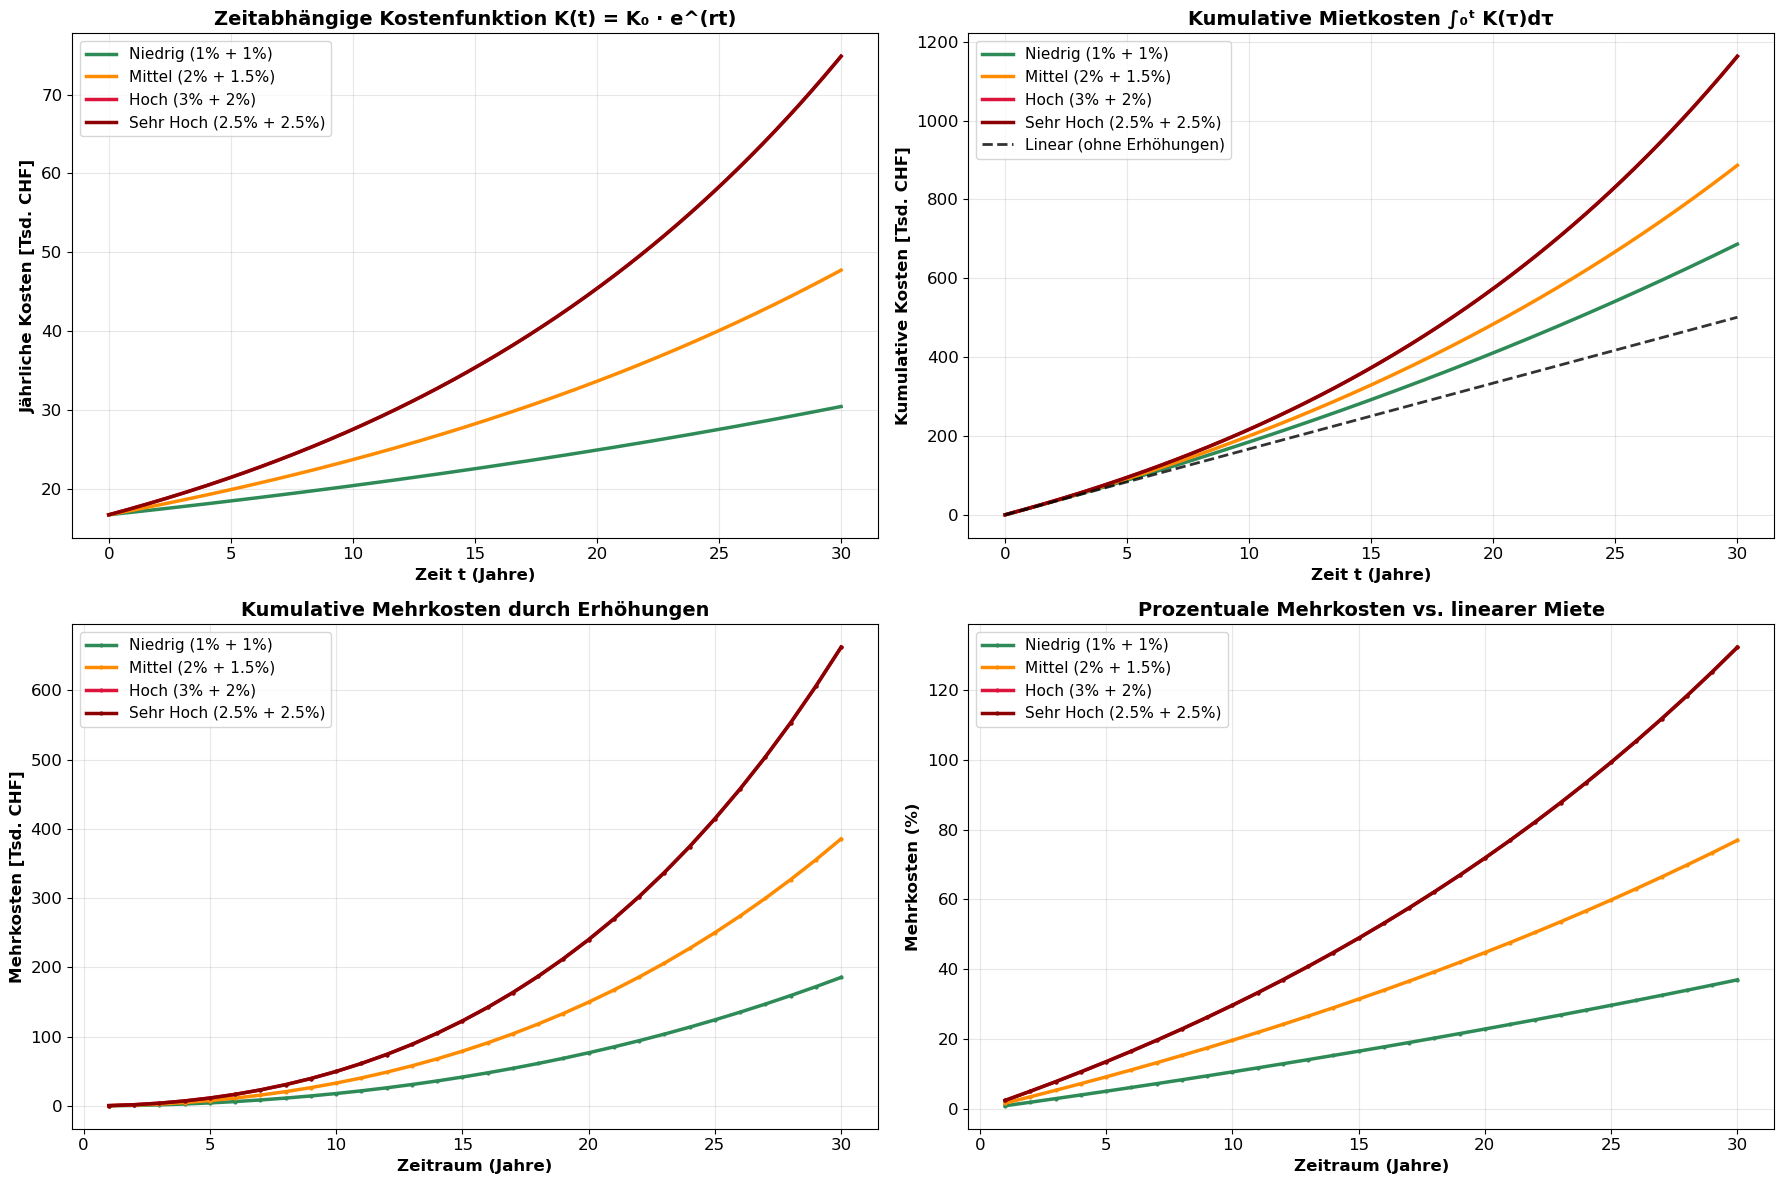

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

t_range = np.linspace(0, 30, 300)

scenarios = [
    (0.01, 0.01, 'Niedrig (1% + 1%)', '#2E8B57'),
    (0.02, 0.015, 'Mittel (2% + 1.5%)', '#FF8C00'),
    (0.03, 0.02, 'Hoch (3% + 2%)', '#DC143C'),
    (0.025, 0.025, 'Sehr Hoch (2.5% + 2.5%)', '#8B0000')
]

for inflation, mieterhöhung, label, color in scenarios:
    kosten_func = MietKostenFunktion(schweiz_total, apartment_size, inflation, mieterhöhung)
    k_values = [kosten_func.kostenfunktion(t) for t in t_range]
    axes[0,0].plot(t_range, np.array(k_values)/1000, label=label, color=color, linewidth=2.5)

axes[0,0].set_xlabel('Zeit t (Jahre)', fontsize=12, fontweight='bold')
axes[0,0].set_ylabel('Jährliche Kosten [Tsd. CHF]', fontsize=12, fontweight='bold')
axes[0,0].set_title('Zeitabhängige Kostenfunktion K(t) = K₀ · e^(rt)', fontsize=14, fontweight='bold')
axes[0,0].legend(fontsize=11)
axes[0,0].grid(True, alpha=0.3)

for inflation, mieterhöhung, label, color in scenarios:
    kosten_func = MietKostenFunktion(schweiz_total, apartment_size, inflation, mieterhöhung)
    cumulative_costs = []
    
    for t in t_range:
        if t == 0:
            cumulative_costs.append(0)
        else:
            cost, _ = kosten_func.kumulative_kosten(0, t)
            cumulative_costs.append(cost)
    
    axes[0,1].plot(t_range, np.array(cumulative_costs)/1000, label=label, color=color, linewidth=2.5)

linear_costs = [(schweiz_total * apartment_size * 12 * t)/1000 for t in t_range]
axes[0,1].plot(t_range, linear_costs, '--', color='black', alpha=0.8, linewidth=2, label='Linear (ohne Erhöhungen)')

axes[0,1].set_xlabel('Zeit t (Jahre)', fontsize=12, fontweight='bold')
axes[0,1].set_ylabel('Kumulative Kosten [Tsd. CHF]', fontsize=12, fontweight='bold')
axes[0,1].set_title('Kumulative Mietkosten ∫₀ᵗ K(τ)dτ', fontsize=14, fontweight='bold')
axes[0,1].legend(fontsize=11)
axes[0,1].grid(True, alpha=0.3)

mehrkosten_data = []
zeitraum_range = np.arange(1, 31)

for inflation, mieterhöhung, label, color in scenarios:
    mehrkosten = []
    for t in zeitraum_range:
        kosten_func = MietKostenFunktion(schweiz_total, apartment_size, inflation, mieterhöhung)
        kumulative, _ = kosten_func.kumulative_kosten(0, t)
        linear = schweiz_total * apartment_size * 12 * t
        mehrkosten.append((kumulative - linear) / 1000)
    
    axes[1,0].plot(zeitraum_range, mehrkosten, label=label, color=color, linewidth=2.5, marker='o', markersize=2)

axes[1,0].set_xlabel('Zeitraum (Jahre)', fontsize=12, fontweight='bold')
axes[1,0].set_ylabel('Mehrkosten [Tsd. CHF]', fontsize=12, fontweight='bold')
axes[1,0].set_title('Kumulative Mehrkosten durch Erhöhungen', fontsize=14, fontweight='bold')
axes[1,0].legend(fontsize=11)
axes[1,0].grid(True, alpha=0.3)

for inflation, mieterhöhung, label, color in scenarios:
    prozent_mehrkosten = []
    for t in zeitraum_range:
        kosten_func = MietKostenFunktion(schweiz_total, apartment_size, inflation, mieterhöhung)
        kumulative, _ = kosten_func.kumulative_kosten(0, t)
        linear = schweiz_total * apartment_size * 12 * t
        prozent = ((kumulative - linear) / linear) * 100
        prozent_mehrkosten.append(prozent)
    
    axes[1,1].plot(zeitraum_range, prozent_mehrkosten, label=label, color=color, linewidth=2.5, marker='o', markersize=2)

axes[1,1].set_xlabel('Zeitraum (Jahre)', fontsize=12, fontweight='bold')
axes[1,1].set_ylabel('Mehrkosten (%)', fontsize=12, fontweight='bold')
axes[1,1].set_title('Prozentuale Mehrkosten vs. linearer Miete', fontsize=14, fontweight='bold')
axes[1,1].legend(fontsize=11)
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

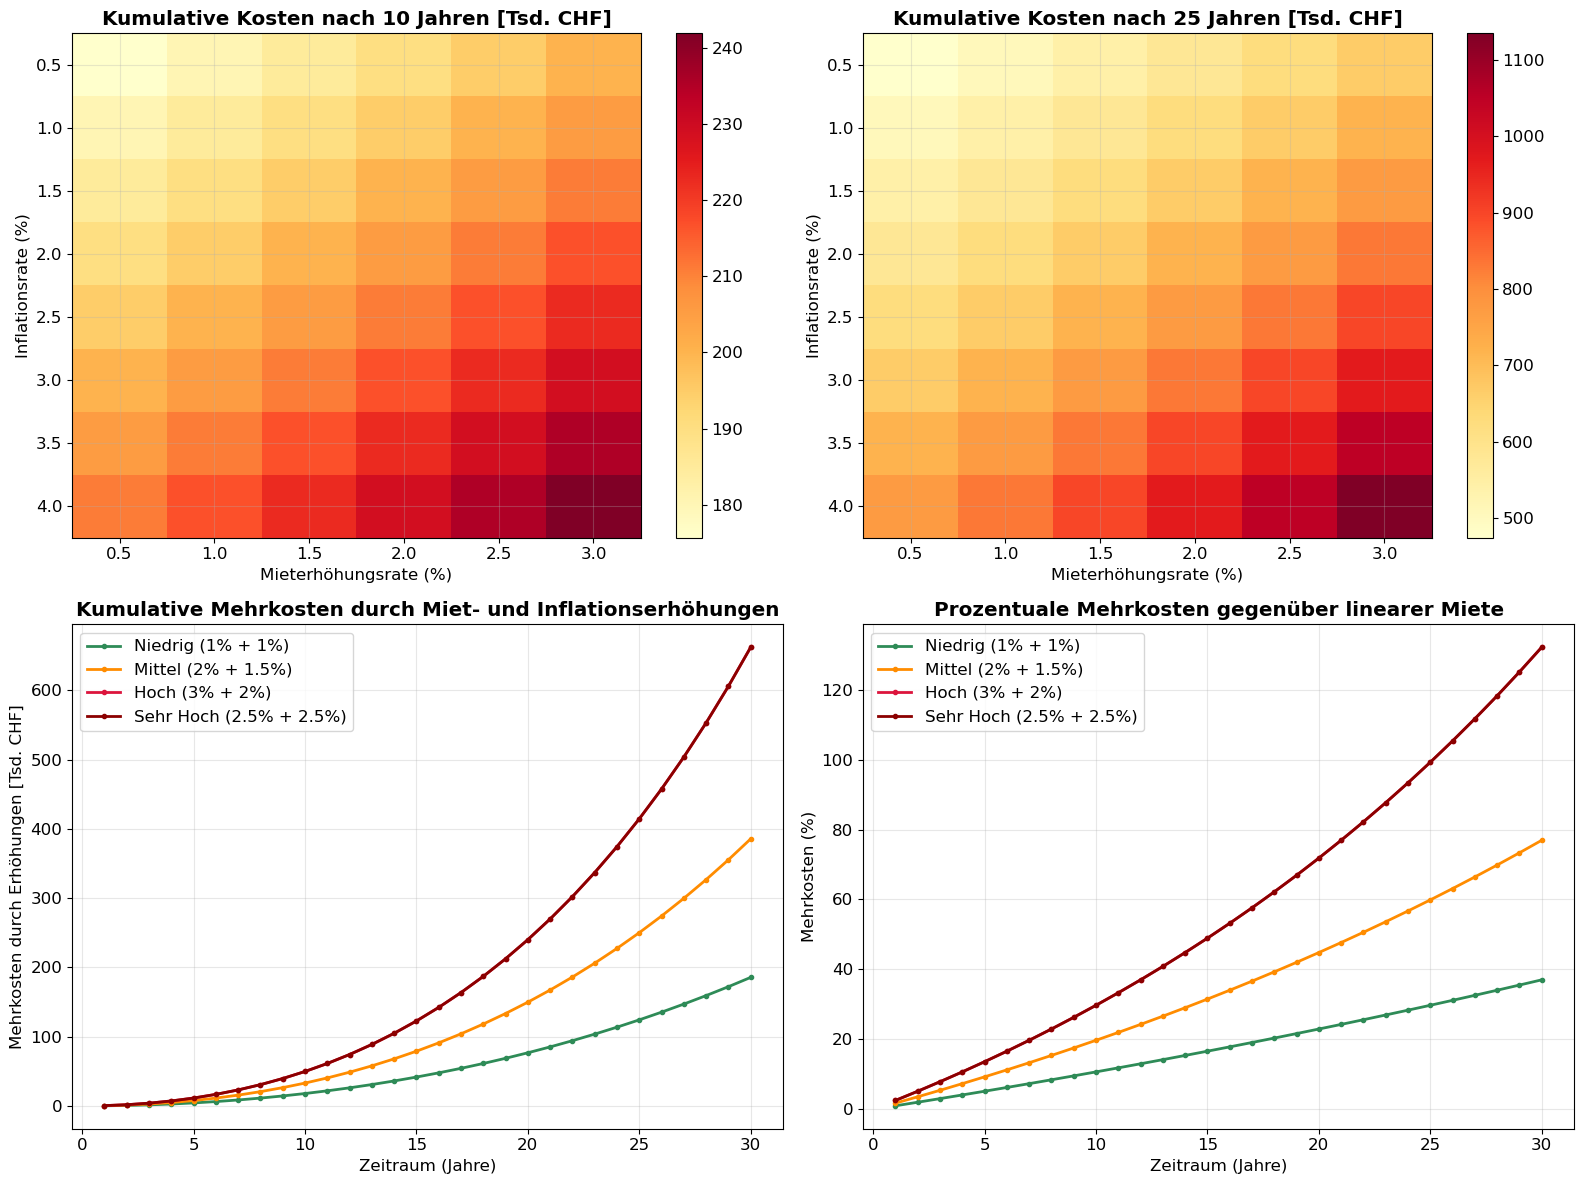

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

zeiträume_heatmap = [5, 10, 15, 20, 25, 30]
inflation_range = np.arange(0.005, 0.041, 0.005)
mieterhöhung_range = np.arange(0.005, 0.031, 0.005)

kosten_matrix_10 = np.zeros((len(inflation_range), len(mieterhöhung_range)))
for i, inflation in enumerate(inflation_range):
    for j, mieterhöhung in enumerate(mieterhöhung_range):
        kosten_func = MietKostenFunktion(schweiz_total, apartment_size, inflation, mieterhöhung)
        kumulative_kosten, _ = kosten_func.kumulative_kosten(0, 10)
        kosten_matrix_10[i, j] = kumulative_kosten / 1000

im1 = axes[0,0].imshow(kosten_matrix_10, cmap='YlOrRd', aspect='auto')
axes[0,0].set_title('Kumulative Kosten nach 10 Jahren [Tsd. CHF]', fontweight='bold')
axes[0,0].set_xlabel('Mieterhöhungsrate (%)')
axes[0,0].set_ylabel('Inflationsrate (%)')
axes[0,0].set_xticks(range(len(mieterhöhung_range)))
axes[0,0].set_xticklabels([f'{r*100:.1f}' for r in mieterhöhung_range])
axes[0,0].set_yticks(range(len(inflation_range)))
axes[0,0].set_yticklabels([f'{r*100:.1f}' for r in inflation_range])
plt.colorbar(im1, ax=axes[0,0])

kosten_matrix_25 = np.zeros((len(inflation_range), len(mieterhöhung_range)))
for i, inflation in enumerate(inflation_range):
    for j, mieterhöhung in enumerate(mieterhöhung_range):
        kosten_func = MietKostenFunktion(schweiz_total, apartment_size, inflation, mieterhöhung)
        kumulative_kosten, _ = kosten_func.kumulative_kosten(0, 25)
        kosten_matrix_25[i, j] = kumulative_kosten / 1000

im2 = axes[0,1].imshow(kosten_matrix_25, cmap='YlOrRd', aspect='auto')
axes[0,1].set_title('Kumulative Kosten nach 25 Jahren [Tsd. CHF]', fontweight='bold')
axes[0,1].set_xlabel('Mieterhöhungsrate (%)')
axes[0,1].set_ylabel('Inflationsrate (%)')
axes[0,1].set_xticks(range(len(mieterhöhung_range)))
axes[0,1].set_xticklabels([f'{r*100:.1f}' for r in mieterhöhung_range])
axes[0,1].set_yticks(range(len(inflation_range)))
axes[0,1].set_yticklabels([f'{r*100:.1f}' for r in inflation_range])
plt.colorbar(im2, ax=axes[0,1])

zeitraum_range = np.arange(1, 31)
mehrkosten_szenarien = []

for inflation, mieterhöhung, label, color in scenarios:
    mehrkosten = []
    for t in zeitraum_range:
        kosten_func = MietKostenFunktion(schweiz_total, apartment_size, inflation, mieterhöhung)
        kumulative, _ = kosten_func.kumulative_kosten(0, t)
        linear = schweiz_total * apartment_size * 12 * t
        mehrkosten.append((kumulative - linear) / 1000)
    
    axes[1,0].plot(zeitraum_range, mehrkosten, label=label, color=color, linewidth=2, marker='o', markersize=3)

axes[1,0].set_xlabel('Zeitraum (Jahre)')
axes[1,0].set_ylabel('Mehrkosten durch Erhöhungen [Tsd. CHF]')
axes[1,0].set_title('Kumulative Mehrkosten durch Miet- und Inflationserhöhungen', fontweight='bold')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

for inflation, mieterhöhung, label, color in scenarios:
    prozent_mehrkosten = []
    for t in zeitraum_range:
        kosten_func = MietKostenFunktion(schweiz_total, apartment_size, inflation, mieterhöhung)
        kumulative, _ = kosten_func.kumulative_kosten(0, t)
        linear = schweiz_total * apartment_size * 12 * t
        prozent = ((kumulative - linear) / linear) * 100
        prozent_mehrkosten.append(prozent)
    
    axes[1,1].plot(zeitraum_range, prozent_mehrkosten, label=label, color=color, linewidth=2, marker='o', markersize=3)

axes[1,1].set_xlabel('Zeitraum (Jahre)')
axes[1,1].set_ylabel('Mehrkosten (%)')
axes[1,1].set_title('Prozentuale Mehrkosten gegenüber linearer Miete', fontweight='bold')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [9]:
if len(df['Kanton'].unique()) > 1:
    print("Verfügbare Kantone vor Bereinigung:")
    print(df['Kanton'].value_counts())
    
    kantone_total = {}
    
    for entry in rental_data:
        year = entry['year']
        canton = entry['canton']
        
        for period_data in entry['construction_periods']:
            if period_data['construction_period'] == 'Total':
                if canton not in kantone_total or int(year) > int(kantone_total[canton]['Jahr']):
                    kantone_total[canton] = {
                        'Kanton': canton,
                        'Jahr': year,
                        'Mietpreis_Total': period_data['avg_price_per_sqm'],
                        'Konfidenzintervall': period_data['confidence_interval']
                    }
    
    if kantone_total:
        kantone_df = pd.DataFrame(list(kantone_total.values()))
        
        print(f"\nBereinigte Kantone ({len(kantone_df)} eindeutige Einträge):")
        print(kantone_df[['Kanton', 'Jahr', 'Mietpreis_Total']].to_string(index=False))
        
        zeitraum = 25
        inflation = 0.02
        mieterhöhung = 0.015
        
        kumulative_kosten_kantone = []
        for _, row in kantone_df.iterrows():
            kosten_func = MietKostenFunktion(row['Mietpreis_Total'], apartment_size, inflation, mieterhöhung)
            kumulative, _ = kosten_func.kumulative_kosten(0, zeitraum)
            kumulative_kosten_kantone.append(kumulative / 1000)
        
        kantone_df['Kumulative_Kosten_25J'] = kumulative_kosten_kantone
        kantone_df_sorted = kantone_df.sort_values('Mietpreis_Total', ascending=True)
        
        print("Kantons-Datenaufbereitung abgeschlossen")
    else:
        print("Keine 'Total' Daten für Kantone gefunden")
else:
    print("Nur ein Kanton in den Daten verfügbar. Kantons-Vergleich übersprungen.")

Verfügbare Kantone vor Bereinigung:
Kanton
Schweiz             107
Zürich              107
Genf                107
Neuenburg           107
Wallis              107
Waadt               107
Tessin              107
Thurgau             107
Aargau              107
Graubünden          107
St.Gallen           107
Appenzell A.Rh.     107
Schaffhausen        107
Basel-Landschaft    107
Basel-Stadt         107
Solothurn           107
Freiburg            107
Zug                 107
Nidwalden           107
Obwalden            107
Schwyz              107
Uri                 107
Luzern              107
Bern                107
Jura                107
Glarus              106
Appenzell I.Rh.      96
Name: count, dtype: int64

Bereinigte Kantone (27 eindeutige Einträge):
          Kanton Jahr  Mietpreis_Total
         Schweiz 2023             17.4
          Zürich 2023             20.7
            Bern 2023             15.7
          Luzern 2023             16.4
             Uri 2023             13.5
   

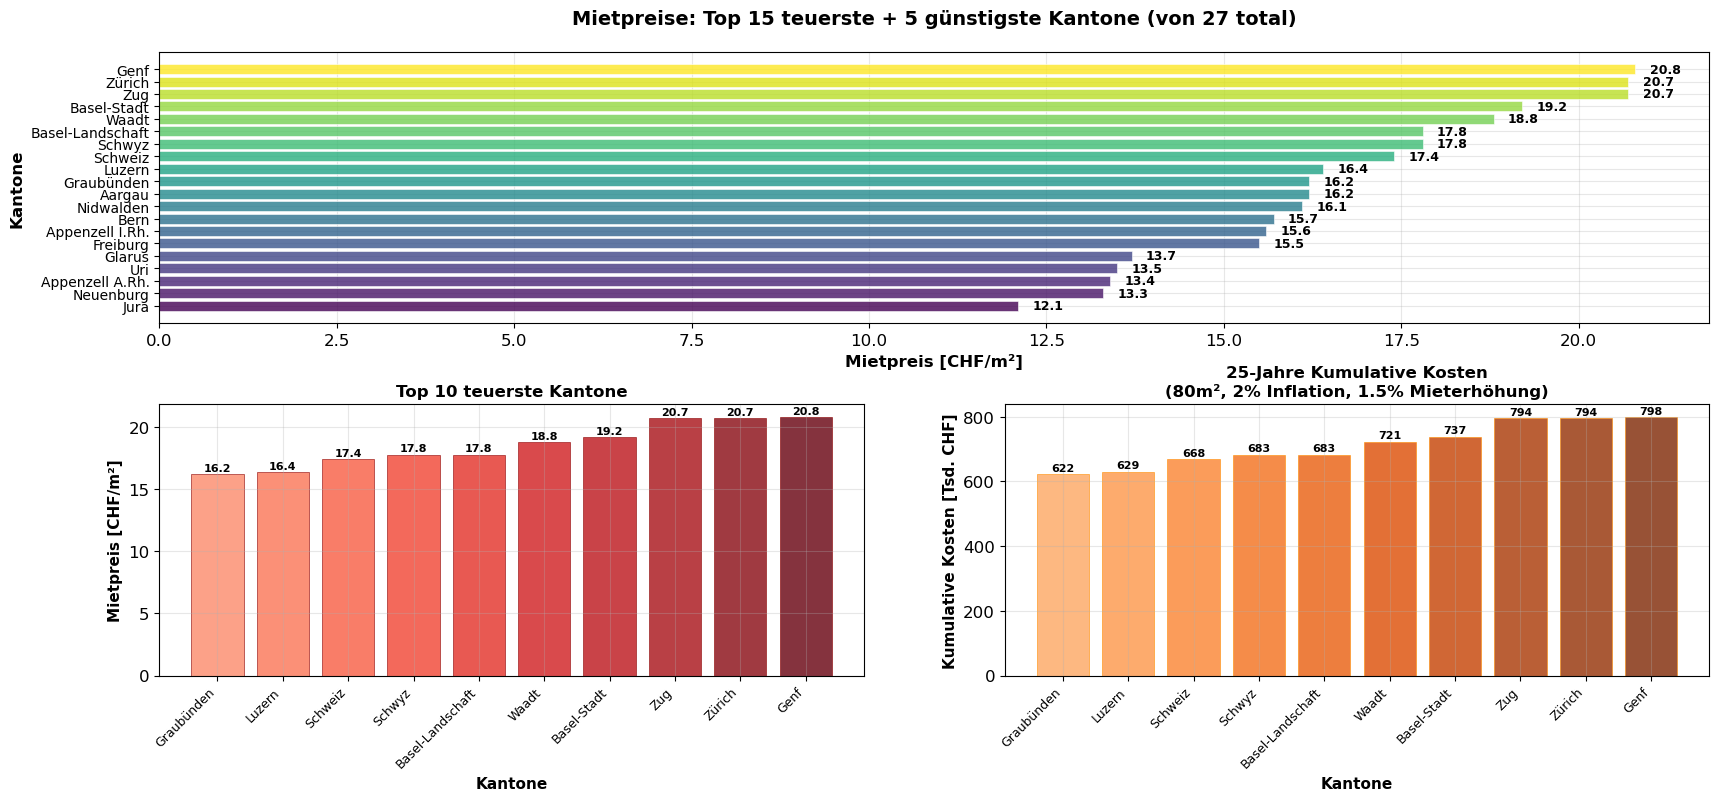

Kantons-Vergleichsvisualisierung erstellt


In [10]:
if len(df['Kanton'].unique()) > 1 and 'kantone_df' in locals():
    n_kantone = len(kantone_df_sorted)
    
    fig = plt.figure(figsize=(20, max(8, n_kantone * 0.3)))
    
    if n_kantone <= 15:
        gs = fig.add_gridspec(2, 2, height_ratios=[1, 1], hspace=0.3, wspace=0.2)
        show_top_10_only = False
    else:
        gs = fig.add_gridspec(2, 2, height_ratios=[1, 1], hspace=0.3, wspace=0.2)
        show_top_10_only = True
    
    if show_top_10_only:
        ax1 = fig.add_subplot(gs[0, :])
        top_15 = kantone_df_sorted.tail(15)
        bottom_5 = kantone_df_sorted.head(5)
        display_df = pd.concat([bottom_5, top_15]).drop_duplicates()
    else:
        ax1 = fig.add_subplot(gs[0, :])
        display_df = kantone_df_sorted
    
    colors1 = plt.cm.viridis(np.linspace(0, 1, len(display_df)))
    
    bars1 = ax1.barh(range(len(display_df)), display_df['Mietpreis_Total'], 
                    color=colors1, alpha=0.8, edgecolor='white', linewidth=0.5)
    
    ax1.set_xlabel('Mietpreis [CHF/m²]', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Kantone', fontsize=12, fontweight='bold')
    
    if show_top_10_only:
        ax1.set_title(f'Mietpreise: Top 15 teuerste + 5 günstigste Kantone (von {n_kantone} total)', 
                     fontsize=14, fontweight='bold', pad=20)
    else:
        ax1.set_title('Durchschnittliche Mietpreise pro Kanton (2023) - Sortiert nach Preis', 
                     fontsize=14, fontweight='bold', pad=20)
    
    ax1.set_yticks(range(len(display_df)))
    ax1.set_yticklabels(display_df['Kanton'], fontsize=10)
    
    for i, (bar, value) in enumerate(zip(bars1, display_df['Mietpreis_Total'])):
        ax1.text(bar.get_width() + 0.2, bar.get_y() + bar.get_height()/2, 
                f'{value:.1f}', ha='left', va='center', fontweight='bold', fontsize=9)
    
    ax1.grid(True, axis='x', alpha=0.3)
    ax1.set_axisbelow(True)
    
    ax2 = fig.add_subplot(gs[1, 0])
    top_10_teuer = kantone_df_sorted.tail(min(10, n_kantone))
    
    bars2 = ax2.bar(range(len(top_10_teuer)), top_10_teuer['Mietpreis_Total'], 
                   color=plt.cm.Reds(np.linspace(0.4, 1, len(top_10_teuer))), 
                   alpha=0.8, edgecolor='darkred', linewidth=0.5)
    
    ax2.set_xlabel('Kantone', fontsize=11, fontweight='bold')
    ax2.set_ylabel('Mietpreis [CHF/m²]', fontsize=11, fontweight='bold')
    ax2.set_title(f'Top {min(10, n_kantone)} teuerste Kantone', fontsize=12, fontweight='bold')
    ax2.set_xticks(range(len(top_10_teuer)))
    ax2.set_xticklabels(top_10_teuer['Kanton'], rotation=45, ha='right', fontsize=9)
    
    for bar, value in zip(bars2, top_10_teuer['Mietpreis_Total']):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
                f'{value:.1f}', ha='center', va='bottom', fontweight='bold', fontsize=8)
    
    ax2.grid(True, axis='y', alpha=0.3)
    
    ax3 = fig.add_subplot(gs[1, 1])
    
    bars3 = ax3.bar(range(len(top_10_teuer)), top_10_teuer['Kumulative_Kosten_25J'], 
                   color=plt.cm.Oranges(np.linspace(0.4, 1, len(top_10_teuer))), 
                   alpha=0.8, edgecolor='darkorange', linewidth=0.5)
    
    ax3.set_xlabel('Kantone', fontsize=11, fontweight='bold')
    ax3.set_ylabel('Kumulative Kosten [Tsd. CHF]', fontsize=11, fontweight='bold')
    ax3.set_title('25-Jahre Kumulative Kosten\n(80m², 2% Inflation, 1.5% Mieterhöhung)', 
                 fontsize=12, fontweight='bold')
    ax3.set_xticks(range(len(top_10_teuer)))
    ax3.set_xticklabels(top_10_teuer['Kanton'], rotation=45, ha='right', fontsize=9)
    
    for bar, value in zip(bars3, top_10_teuer['Kumulative_Kosten_25J']):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
                f'{value:.0f}', ha='center', va='bottom', fontweight='bold', fontsize=8)
    
    ax3.grid(True, axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("Kantons-Vergleichsvisualisierung erstellt")
else:
    print("Kantons-Vergleichsvisualisierung übersprungen - nicht genügend Daten")

In [11]:
if len(df['Kanton'].unique()) > 1 and 'kantone_df' in locals():
    print("\n" + "="*90)
    print("DETAILLIERTE KANTONS-ÜBERSICHT (BEREINIGTE DATEN)")
    print("="*90)
    
    kantone_df_kosten_sorted = kantone_df.sort_values('Kumulative_Kosten_25J', ascending=False)
    
    print(f"{'Rang':<4} {'Kanton':<15} {'Jahr':<6} {'Miete/m²':<10} {'25J Total':<12} {'Differenz zu CH':<15}")
    print("-" * 90)
    
    schweiz_kosten = None
    if 'Schweiz' in kantone_df['Kanton'].values:
        schweiz_kosten = kantone_df[kantone_df['Kanton'] == 'Schweiz']['Kumulative_Kosten_25J'].iloc[0]
    
    for i, (_, row) in enumerate(kantone_df_kosten_sorted.iterrows(), 1):
        differenz = ""
        if schweiz_kosten is not None:
            diff = row['Kumulative_Kosten_25J'] - schweiz_kosten
            differenz = f"{diff:+6.0f} CHF"
        
        print(f"{i:<4} {row['Kanton']:<15} {row['Jahr']:<6} {row['Mietpreis_Total']:<10.1f} "
              f"{row['Kumulative_Kosten_25J']:<12.0f} {differenz:<15}")
    
    print(f"\nSTATISTIKEN:")
    print(f"• Anzahl eindeutige Kantone: {len(kantone_df)}")
    print(f"• Günstigster Kanton: {kantone_df_kosten_sorted.iloc[-1]['Kanton']} "
          f"({kantone_df_kosten_sorted.iloc[-1]['Mietpreis_Total']:.1f} CHF/m²)")
    print(f"• Teuerster Kanton: {kantone_df_kosten_sorted.iloc[0]['Kanton']} "
          f"({kantone_df_kosten_sorted.iloc[0]['Mietpreis_Total']:.1f} CHF/m²)")
    print(f"• Preisunterschied: {kantone_df_kosten_sorted.iloc[0]['Mietpreis_Total'] - kantone_df_kosten_sorted.iloc[-1]['Mietpreis_Total']:.1f} CHF/m²")
    print(f"• 25J-Kostenunterschied: {(kantone_df_kosten_sorted.iloc[0]['Kumulative_Kosten_25J'] - kantone_df_kosten_sorted.iloc[-1]['Kumulative_Kosten_25J']):.0f}k CHF")
else:
    print("Kantons-Detailanalyse übersprungen - nicht genügend Daten")


DETAILLIERTE KANTONS-ÜBERSICHT (BEREINIGTE DATEN)
Rang Kanton          Jahr   Miete/m²   25J Total    Differenz zu CH
------------------------------------------------------------------------------------------
1    Genf            2023   20.8       798            +130 CHF     
2    Zug             2023   20.7       794            +127 CHF     
3    Zürich          2023   20.7       794            +127 CHF     
4    Basel-Stadt     2023   19.2       737             +69 CHF     
5    Waadt           2023   18.8       721             +54 CHF     
6    Basel-Landschaft 2023   17.8       683             +15 CHF     
7    Schwyz          2023   17.8       683             +15 CHF     
8    Schweiz         2023   17.4       668              +0 CHF     
9    Luzern          2023   16.4       629             -38 CHF     
10   Graubünden      2023   16.2       622             -46 CHF     
11   Aargau          2023   16.2       622             -46 CHF     
12   Nidwalden       2023   16.1       61

In [12]:
print("="*80)
print("DATENQUALITÄTSPRÜFUNG")
print("="*80)

print(f"Gesamtanzahl Zeilen im DataFrame: {len(df)}")
print(f"Eindeutige Kantone: {len(df['Kanton'].unique())}")
print(f"Eindeutige Jahre: {df['Jahr'].unique() if 'Jahr' in df.columns else 'Nicht verfügbar'}")

print(f"\nVerteilung der Kantone im ursprünglichen DataFrame:")
kanton_counts = df['Kanton'].value_counts()
print(kanton_counts.head(10))

print(f"\nBauperioden im Datensatz:")
if 'Bauperiode' in df.columns:
    print(df['Bauperiode'].unique())

print(f"\nStruktur der ursprünglichen JSON-Daten:")
print(f"Anzahl Einträge: {len(rental_data)}")
for i, entry in enumerate(rental_data[:3]):
    print(f"  Eintrag {i+1}: Jahr {entry['year']}, Kanton {entry['canton']}, "
          f"{len(entry['construction_periods'])} Bauperioden")
    
    total_found = False
    for period in entry['construction_periods']:
        if period['construction_period'] == 'Total':
            total_found = True
            print(f"    -> Total gefunden: {period['avg_price_per_sqm']} CHF/m²")
            break
    if not total_found:
        print(f"    -> KEIN 'Total' gefunden!")

print(f"\nVerwendete Filtermethode:")
print("1. Iteriere durch alle JSON-Einträge")
print("2. Für jeden Eintrag: suche 'construction_period' == 'Total'")
print("3. Pro Kanton nur den neuesten Jahrgang behalten")
print("4. Dictionary verwenden um Duplikate zu vermeiden")

DATENQUALITÄTSPRÜFUNG
Gesamtanzahl Zeilen im DataFrame: 2877
Eindeutige Kantone: 27
Eindeutige Jahre: [2023 2022 2021 2020 2019 2018 2017 2016 2015 2014 2013 2012]

Verteilung der Kantone im ursprünglichen DataFrame:
Kanton
Schweiz       107
Zürich        107
Genf          107
Neuenburg     107
Wallis        107
Waadt         107
Tessin        107
Thurgau       107
Aargau        107
Graubünden    107
Name: count, dtype: int64

Bauperioden im Datensatz:
['Vor 1919' '1919 - 1945' '1946 - 1960' '1961 - 1970' '1971 - 1980'
 '1981 - 1990' '1991 - 2000' '2001-2010' '2011-2020' '2021-2023'
 '2011-2022' '2011-2021' '2011-2019' '2011-2018' '2011-2017' '2011-2016'
 '2011-2015' '2011-2014' '2001-2013' '2001-2012']

Struktur der ursprünglichen JSON-Daten:
Anzahl Einträge: 324
  Eintrag 1: Jahr 2023, Kanton Schweiz, 11 Bauperioden
    -> Total gefunden: 17.4 CHF/m²
  Eintrag 2: Jahr 2023, Kanton Zürich, 11 Bauperioden
    -> Total gefunden: 20.7 CHF/m²
  Eintrag 3: Jahr 2023, Kanton Bern, 11 Bauper

In [8]:
print("=" * 60)
print("MATHEMATISCHE LÖSUNG DER INTEGRATION")
print("=" * 60)
print("Kostenfunktion: K(t) = K₀ · e^(rt)")
print("Integration: ∫₀ᵗ K₀ · e^(rτ) dτ = K₀ · [e^(rt) - 1] / r")
print(f"Wobei K₀ = {schweiz_total * apartment_size * 12:,.0f} CHF (jährliche Grundmiete)")

kosten_func_beispiel = MietKostenFunktion(schweiz_total, apartment_size, 0.02, 0.015)

print(f"\nGRUNDDATA:")
print(f"• Wohnungsgröße: {apartment_size} m²")
print(f"• Grundmiete Schweiz: {schweiz_total} CHF/m²")
print(f"• Monatliche Grundmiete: {schweiz_total * apartment_size:,.0f} CHF")
print(f"• Jährliche Grundmiete: {schweiz_total * apartment_size * 12:,.0f} CHF")

print(f"\nMATHEMATISCHES MODELL:")
print(f"• Kostenfunktion: K(t) = K₀ · e^(rt)")
print(f"• Wobei r = Inflation + Mieterhöhung = 2% + 1.5% = 3.5%")
print(f"• Integration: ∫₀ᵗ K(t)dt = K₀ · [e^(rt) - 1] / r")

print(f"\nBEISPIELRESULTATE (2% Inflation, 1.5% Mieterhöhung):")

zeiträume_beispiel = [5, 10, 15, 20, 25, 30]
for t in zeiträume_beispiel:
    kumulative, _ = kosten_func_beispiel.kumulative_kosten(0, t)
    linear = schweiz_total * apartment_size * 12 * t
    mehrkosten = kumulative - linear
    prozent_mehr = (mehrkosten / linear) * 100
    
    print(f"• {t:2d} Jahre: {kumulative:8,.0f} CHF total | {mehrkosten:6,.0f} CHF Mehrkosten (+{prozent_mehr:.1f}%)")

print(f"\nSENSITIVITÄTSANALYSE (25 Jahre):")
base_kumulative, _ = kosten_func_beispiel.kumulative_kosten(0, 25)

for delta in [0.005, 0.01]:
    kosten_func_höher = MietKostenFunktion(schweiz_total, apartment_size, 0.02, 0.015 + delta)
    höhere_kumulative, _ = kosten_func_höher.kumulative_kosten(0, 25)
    unterschied = höhere_kumulative - base_kumulative
    
    print(f"• +{delta*100:.1f}% höhere Mieterhöhung: +{unterschied:,.0f} CHF Mehrkosten über 25 Jahre")

MATHEMATISCHE LÖSUNG DER INTEGRATION
Kostenfunktion: K(t) = K₀ · e^(rt)
Integration: ∫₀ᵗ K₀ · e^(rτ) dτ = K₀ · [e^(rt) - 1] / r
Wobei K₀ = 16,704 CHF (jährliche Grundmiete)

GRUNDDATA:
• Wohnungsgröße: 80 m²
• Grundmiete Schweiz: 17.4 CHF/m²
• Monatliche Grundmiete: 1,392 CHF
• Jährliche Grundmiete: 16,704 CHF

MATHEMATISCHES MODELL:
• Kostenfunktion: K(t) = K₀ · e^(rt)
• Wobei r = Inflation + Mieterhöhung = 2% + 1.5% = 3.5%
• Integration: ∫₀ᵗ K(t)dt = K₀ · [e^(rt) - 1] / r

BEISPIELRESULTATE (2% Inflation, 1.5% Mieterhöhung):
•  5 Jahre:   91,274 CHF total |  7,754 CHF Mehrkosten (+9.3%)
• 10 Jahre:  200,003 CHF total | 32,963 CHF Mehrkosten (+19.7%)
• 15 Jahre:  329,526 CHF total | 78,966 CHF Mehrkosten (+31.5%)
• 20 Jahre:  483,821 CHF total | 149,741 CHF Mehrkosten (+44.8%)
• 25 Jahre:  667,623 CHF total | 250,023 CHF Mehrkosten (+59.9%)
• 30 Jahre:  886,577 CHF total | 385,457 CHF Mehrkosten (+76.9%)

SENSITIVITÄTSANALYSE (25 Jahre):
• +0.5% höhere Mieterhöhung: +49,931 CHF Mehrko